In [2]:
print(f"Total number of segments: {segments.shape[0]}")
print(f"Shape of each segment: {segments.shape[1:]}")
print(f"Total labels: {labels.shape[0]}")


Total number of segments: 100021
Shape of each segment: (260, 1, 1)
Total labels: 100021


C:\Users\ma23193\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\ma23193\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training Stacked GRU...
Epoch 1/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 167s 66ms/step - accuracy: 0.7471 - loss: 0.9108 - val_accuracy: 0.8783 - val_loss: 0.3731
Epoch 2/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 164s 66ms/step - accuracy: 0.8923 - loss: 0.3408 - val_accuracy: 0.9460 - val_loss: 0.1846
Epoch 3/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 165s 66ms/step - accuracy: 0.9448 - loss: 0.2023 - val_accuracy: 0.9576 - val_loss: 0.1452
Epoch 4/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 165s 66ms/step - accuracy: 0.9581 - loss: 0.1617 - val_accuracy: 0.9655 - val_loss: 0.1267
Epoch 5/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 164s 66ms/step - accuracy: 0.9645 - loss: 0.1409 - val_accuracy: 0.9722 - val_loss: 0.1117
Epoch 6/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 165s 66ms/step - accuracy: 0.9682 - loss: 0.1238 - val_accuracy: 0.9736 - val_loss: 0.0975
Epoch 7/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 165s 66ms/step - accuracy: 0.9715 - loss: 0.1140 - val_accuracy: 0.9729 - val_loss: 0.1044
Epoch 8/40
2501/2501 ━━━━━━━━━━━━━━━━━━━━ 165

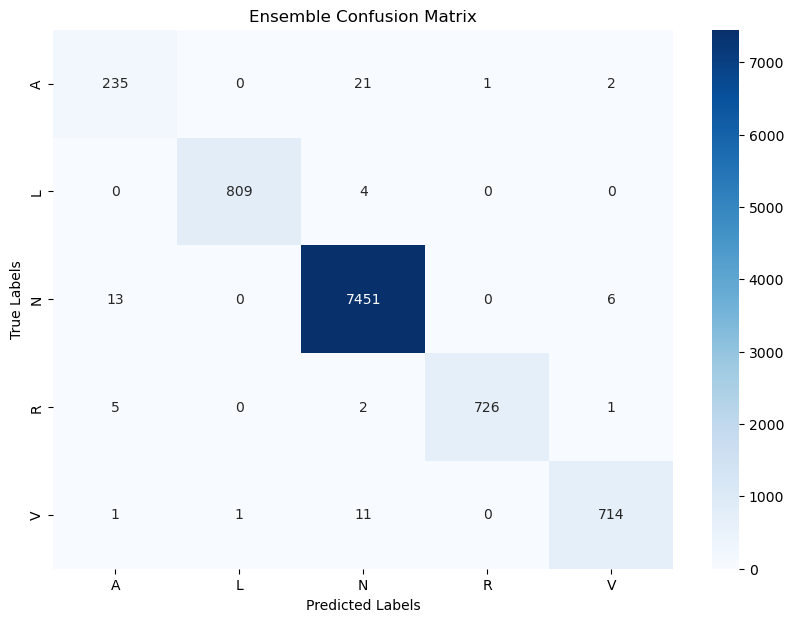

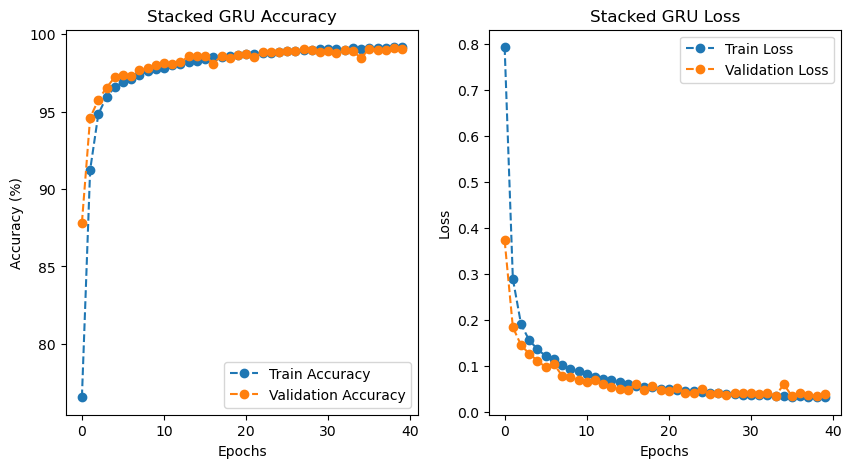

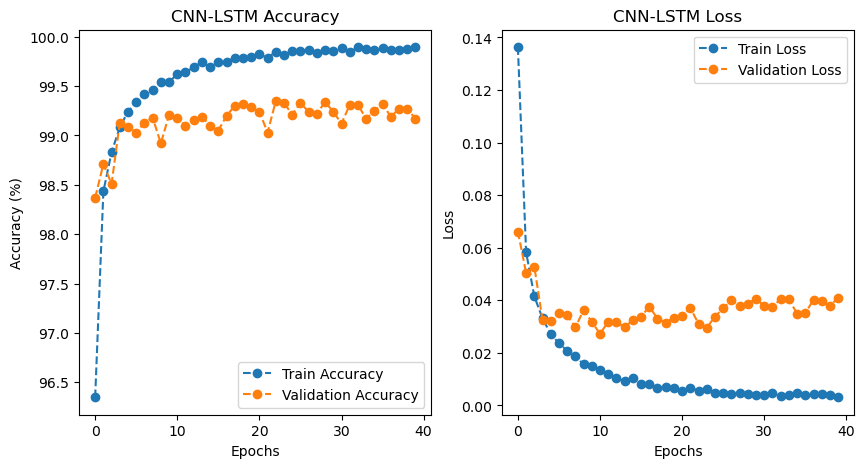

In [1]:
import os
import wfdb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GRU, Reshape, Input, Flatten, LSTM, Dropout
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Define the path to the extracted dataset
data_path = 'M:\\Dissertation\\New folder\\mit-bih-arrhythmia-database-1.0.0'

# Function to load a record and preprocess
def load_and_preprocess(record):
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
   
    # Use only one channel (e.g., channel 0)
    signal = signal[:, 0].reshape(-1, 1)
   
    # Segment the signal
    segments = []
    labels = []
    for i in range(len(annotation.sample)):
        if annotation.sample[i] - 99 > 0 and annotation.sample[i] + 160 < len(signal):
            segments.append(signal[annotation.sample[i] - 99 : annotation.sample[i] + 161])
            labels.append(annotation.symbol[i])
   
    return np.array(segments), np.array(labels)

# Function to load and preprocess all records in the dataset
def load_and_preprocess_all_records(data_path):
    all_segments = []
    all_labels = []
   
    for record in os.listdir(data_path):
        if record.endswith('.dat'):
            record_name = record[:-4]  # Remove the file extension
            segments, labels = load_and_preprocess(record_name)
            all_segments.append(segments)
            all_labels.append(labels)
   
    # Concatenate all segments and labels
    all_segments = np.vstack(all_segments)
    all_labels = np.concatenate(all_labels)
   
    return all_segments, all_labels

# Load and preprocess the entire dataset
segments, labels = load_and_preprocess_all_records(data_path)

# Filter out unwanted labels (keeping only certain labels, e.g., 'N', 'L', 'R', 'A', 'V')
valid_labels = ['N', 'L', 'R', 'A', 'V']
mask = np.isin(labels, valid_labels)
segments = segments[mask]
labels = labels[mask]

# Reshape segments to fit the model's expected input shape
segments = segments.reshape(segments.shape[0], segments.shape[1], 1, 1)

# Encode the labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Convert labels to categorical format
labels_categorical = tf.keras.utils.to_categorical(labels_encoded)

# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(segments, labels_categorical, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 1. Stacked GRU Model with Regularization
def create_stacked_gru(input_shape, num_classes):
    model = Sequential([
        GRU(32, return_sequences=True, input_shape=input_shape),
        GRU(32),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 2. CNN-LSTM Model with Regularization
def create_cnn_lstm(input_shape_cnn, input_shape_lstm, num_classes):
    cnn_model = Sequential([
        Conv2D(32, (5, 1), activation='relu', input_shape=input_shape_cnn),
        MaxPooling2D((2, 1)),
        Conv2D(64, (3, 1), activation='relu'),
        Flatten(),
        Dense(260 * 32, activation='relu')  # Adjusted to match the LSTM input
    ])
   
    cnn_input = Input(shape=input_shape_cnn)
    cnn_output = cnn_model(cnn_input)
   
    # Correctly reshape the CNN output to match LSTM input expectations
    timesteps = input_shape_lstm[0]  # This is typically the length of the input sequence
    features = 32  # Reduced the features to match the Dense layer output
   
    lstm_input = Reshape((timesteps, features))(cnn_output)
    lstm_output = LSTM(32)(lstm_input)
   
    output = Dense(num_classes, activation='softmax')(lstm_output)
   
    model = Model(inputs=cnn_input, outputs=output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the input shape based on your data
input_shape_lstm_gru = (segments.shape[1], 1)  # (timesteps, features) for LSTM/GRU
input_shape_cnn_resnet = (segments.shape[1], 1, 1)  # (timesteps, features, 1) for CNN/ResNet

# Number of classes
num_classes = len(valid_labels)

# Create the models
stacked_gru_model = create_stacked_gru(input_shape_lstm_gru, num_classes)
cnn_lstm_model = create_cnn_lstm(input_shape_cnn_resnet, input_shape_lstm_gru, num_classes)

# Train the models and store history
models = [
    (stacked_gru_model, 'Stacked GRU', 40),
    (cnn_lstm_model, 'CNN-LSTM', 40)
]

histories = {}

for model, name, epochs in models:
    print(f'Training {name}...')
    start_time = time.time()
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val), batch_size=32)
    total_training_time = time.time() - start_time
    print(f"Total Training Time for {name}: {total_training_time:.2f} seconds")
    histories[name] = history

# Predict using the models
y_pred_stacked_gru = stacked_gru_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Ensemble method - Average predictions from the models
y_pred_ensemble = (y_pred_stacked_gru + y_pred_cnn_lstm) / 2
y_pred_classes_ensemble = np.argmax(y_pred_ensemble, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Compute the confusion matrix
conf_matrix_ensemble = confusion_matrix(y_test_classes, y_pred_classes_ensemble)

# Compute the metrics
overall_accuracy_ensemble = np.sum(y_pred_classes_ensemble == y_test_classes) / len(y_test_classes)
overall_sensitivity_ensemble = recall_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100
overall_specificity_ensemble = (conf_matrix_ensemble[0,0] / (conf_matrix_ensemble[0,0] + conf_matrix_ensemble[0,1])) * 100 if conf_matrix_ensemble.shape[0] > 1 else 0
overall_precision_ensemble = precision_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100
overall_fscore_ensemble = f1_score(y_test_classes, y_pred_classes_ensemble, average='macro') * 100

# Print the ensemble results
print(f"Results for Ensemble of Stacked GRU and CNN-LSTM Models:")
print(f"Overall Accuracy: {overall_accuracy_ensemble * 100:.2f}%")
print(f"Overall Sensitivity: {overall_sensitivity_ensemble:.2f}%")
print(f"Overall Specificity: {overall_specificity_ensemble:.2f}%")
print(f"Overall Precision: {overall_precision_ensemble:.2f}%")
print(f"Overall F-Score: {overall_fscore_ensemble:.2f}%")

# Calculate per-class metrics
class_names = label_encoder.inverse_transform(np.arange(num_classes))
accuracy_per_class_ensemble = []
sensitivity_per_class_ensemble = []
specificity_per_class_ensemble = []
precision_per_class_ensemble = []
f1score_per_class_ensemble = []

for i, class_name in enumerate(class_names):
    true_positive = conf_matrix_ensemble[i, i]
    false_positive = np.sum(conf_matrix_ensemble[:, i]) - true_positive
    false_negative = np.sum(conf_matrix_ensemble[i, :]) - true_positive
    true_negative = np.sum(conf_matrix_ensemble) - (true_positive + false_positive + false_negative)
   
    accuracy = (true_positive + true_negative) / np.sum(conf_matrix_ensemble) * 100
    sensitivity = true_positive / (true_positive + false_negative) * 100 if (true_positive + false_negative) > 0 else 0
    specificity = true_negative / (true_negative + false_positive) * 100 if (true_negative + false_positive) > 0 else 0
    precision = true_positive / (true_positive + false_positive) * 100 if (true_positive + false_positive) > 0 else 0
    f1score = (2 * precision * sensitivity) / (precision + sensitivity) if (precision + sensitivity) > 0 else 0
   
    accuracy_per_class_ensemble.append(accuracy)
    sensitivity_per_class_ensemble.append(sensitivity)
    specificity_per_class_ensemble.append(specificity)
    precision_per_class_ensemble.append(precision)
    f1score_per_class_ensemble.append(f1score)

# Display the ensemble results in a DataFrame
performance_df_ensemble = pd.DataFrame({
    'Classes': class_names,
    'Accuracy (%)': accuracy_per_class_ensemble,
    'Sensitivity (%)': sensitivity_per_class_ensemble,
    'Specificity (%)': specificity_per_class_ensemble,
    'Precision (%)': precision_per_class_ensemble,
    'F1 Score (%)': f1score_per_class_ensemble
})

# Add overall accuracy to match the table
performance_df_ensemble['Overall Accuracy (%)'] = overall_accuracy_ensemble * 100

print(performance_df_ensemble)

# Plot ensemble confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Ensemble Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot accuracy and loss graphs for each model
for name, history in histories.items():
    plt.figure(figsize=(10, 5))
   
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(np.array(history.history['accuracy']) * 100, 'o--', label='Train Accuracy')
    plt.plot(np.array(history.history['val_accuracy']) * 100, 'o--', label='Validation Accuracy')
    plt.title(f'{name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
   
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], 'o--', label='Train Loss')
    plt.plot(history.history['val_loss'], 'o--', label='Validation Loss')
    plt.title(f'{name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
   
    plt.show()

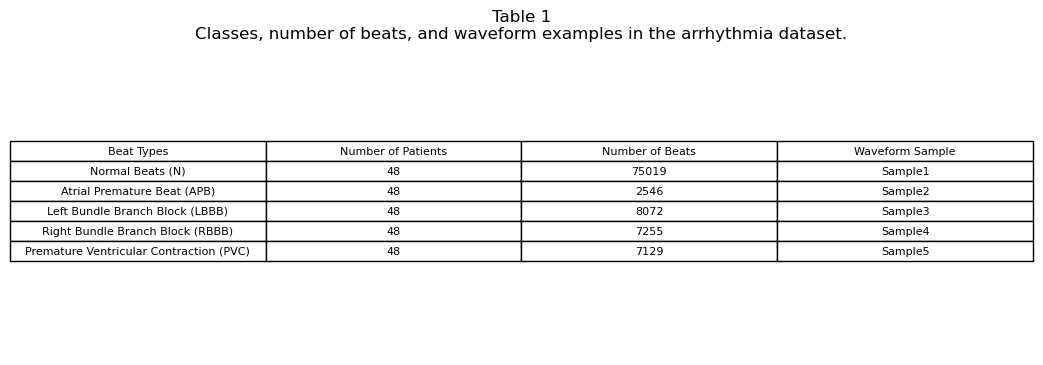

In [5]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Path to the extracted dataset
data_path = 'M:\Dissertation\mit-bih-arrhythmia-database-1.0.0'

# Function to load and preprocess records
def load_and_preprocess(record):
    signal, fields = wfdb.rdsamp(os.path.join(data_path, record))
    annotation = wfdb.rdann(os.path.join(data_path, record), 'atr')
    
    # Use only one channel (e.g., channel 0)
    signal = signal[:, 0].reshape(-1, 1)
    
    # Segment the signal
    segments = []
    labels = []
    for i in range(len(annotation.sample)):
        if annotation.sample[i] - 99 > 0 and annotation.sample[i] + 160 < len(signal):
            segments.append(signal[annotation.sample[i] - 99 : annotation.sample[i] + 161])
            labels.append(annotation.symbol[i])
    
    return np.array(segments), np.array(labels)

# Function to count beats and patients for each label
def count_beats_and_patients(data_path):
    label_counts = {'N': {'patients': set(), 'beats': 0},
                    'L': {'patients': set(), 'beats': 0},
                    'R': {'patients': set(), 'beats': 0},
                    'A': {'patients': set(), 'beats': 0},
                    'V': {'patients': set(), 'beats': 0}}

    for record in os.listdir(data_path):
        if record.endswith('.dat'):
            record_name = record[:-4]  # Remove the file extension
            segments, labels = load_and_preprocess(record_name)
            
            for label in label_counts.keys():
                beats_for_label = labels == label
                label_counts[label]['patients'].add(record_name)
                label_counts[label]['beats'] += np.sum(beats_for_label)

    # Convert sets to number of patients
    for label in label_counts.keys():
        label_counts[label]['patients'] = len(label_counts[label]['patients'])

    return label_counts

# Count the beats and patients
label_counts = count_beats_and_patients(data_path)

# Prepare data for the table
data_for_table = {
    'Beat Types': [
        'Normal Beats (N)', 
        'Atrial Premature Beat (APB)', 
        'Left Bundle Branch Block (LBBB)', 
        'Right Bundle Branch Block (RBBB)', 
        'Premature Ventricular Contraction (PVC)'
    ],
    'Number of Patients': [label_counts['N']['patients'], label_counts['A']['patients'],
                           label_counts['L']['patients'], label_counts['R']['patients'], 
                           label_counts['V']['patients']],
    'Number of Beats': [label_counts['N']['beats'], label_counts['A']['beats'],
                        label_counts['L']['beats'], label_counts['R']['beats'], 
                        label_counts['V']['beats']],
    'Waveform Sample': ['Sample1', 'Sample2', 'Sample3', 'Sample4', 'Sample5']  # Placeholder for waveforms
}

# Convert to DataFrame
df = pd.DataFrame(data_for_table)

# Create the figure and axis for the table
fig, ax = plt.subplots(figsize=(11, 4))

# Hide axes
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_frame_on(False)

# Create the table
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc = 'center', loc='center')

# Style the table
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1.2, 1.2)

# Set title
plt.title('Table 1\nClasses, number of beats, and waveform examples in the arrhythmia dataset.', loc='center')

# Display the table
plt.show()


In [8]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Assuming y_test_classes is your true class labels
# y_pred_stacked_gru and y_pred_cnn_lstm are the predicted probabilities from your models

# Convert predicted probabilities to class labels
y_pred_classes_stacked_gru = np.argmax(y_pred_stacked_gru, axis=1)
y_pred_classes_cnn_lstm = np.argmax(y_pred_cnn_lstm, axis=1)

# Your true labels should also be in numerical form, so convert them if needed
y_test_classes = np.argmax(y_test, axis=1)

# Calculate confusion matrix and metrics for Stacked GRU
conf_matrix_stacked_gru = confusion_matrix(y_test_classes, y_pred_classes_stacked_gru)
accuracy_stacked_gru = accuracy_score(y_test_classes, y_pred_classes_stacked_gru) * 100
sensitivity_stacked_gru = recall_score(y_test_classes, y_pred_classes_stacked_gru, average='macro') * 100
specificity_stacked_gru = (conf_matrix_stacked_gru[0,0] / (conf_matrix_stacked_gru[0,0] + conf_matrix_stacked_gru[0,1])) * 100 if conf_matrix_stacked_gru.shape[0] > 1 else 0
precision_stacked_gru = precision_score(y_test_classes, y_pred_classes_stacked_gru, average='macro') * 100
f1score_stacked_gru = f1_score(y_test_classes, y_pred_classes_stacked_gru, average='macro') * 100

# Calculate confusion matrix and metrics for CNN-LSTM
conf_matrix_cnn_lstm = confusion_matrix(y_test_classes, y_pred_classes_cnn_lstm)
accuracy_cnn_lstm = accuracy_score(y_test_classes, y_pred_classes_cnn_lstm) * 100
sensitivity_cnn_lstm = recall_score(y_test_classes, y_pred_classes_cnn_lstm, average='macro') * 100
specificity_cnn_lstm = (conf_matrix_cnn_lstm[0,0] / (conf_matrix_cnn_lstm[0,0] + conf_matrix_cnn_lstm[0,1])) * 100 if conf_matrix_cnn_lstm.shape[0] > 1 else 0
precision_cnn_lstm = precision_score(y_test_classes, y_pred_classes_cnn_lstm, average='macro') * 100
f1score_cnn_lstm = f1_score(y_test_classes, y_pred_classes_cnn_lstm, average='macro') * 100

# Print out the metrics
print("Stacked GRU Model:")
print(f"Accuracy: {accuracy_stacked_gru:.2f}%")
print(f"Sensitivity: {sensitivity_stacked_gru:.2f}%")
print(f"Specificity: {specificity_stacked_gru:.2f}%")
print(f"Precision: {precision_stacked_gru:.2f}%")
print(f"F1 Score: {f1score_stacked_gru:.2f}%")

print("\nCNN-LSTM Model:")
print(f"Accuracy: {accuracy_cnn_lstm:.2f}%")
print(f"Sensitivity: {sensitivity_cnn_lstm:.2f}%")
print(f"Specificity: {specificity_cnn_lstm:.2f}%")
print(f"Precision: {precision_cnn_lstm:.2f}%")
print(f"F1 Score: {f1score_cnn_lstm:.2f}%")


Stacked GRU Model:
Accuracy: 99.05%
Sensitivity: 96.44%
Specificity: 100.00%
Precision: 97.65%
F1 Score: 97.03%

CNN-LSTM Model:
Accuracy: 99.06%
Sensitivity: 96.91%
Specificity: 100.00%
Precision: 97.06%
F1 Score: 96.98%


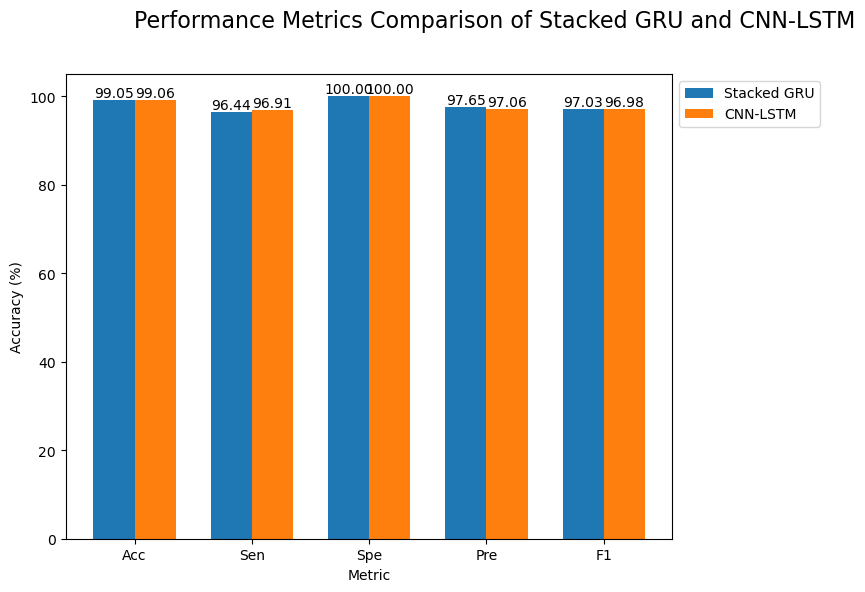

In [26]:
# Provided metrics for the Stacked GRU and CNN-LSTM models
stacked_gru_metrics = [99.05, 96.44, 100, 97.65, 97.03]  # Stacked GRU metrics
cnn_lstm_metrics = [99.06, 96.91, 100, 97.06, 96.98]  # CNN-LSTM metrics

metrics = ['Acc', 'Sen', 'Spe', 'Pre', 'F1']  # Metrics to be displayed
models = ['Stacked GRU', 'CNN-LSTM']

# Combine the metrics into a numpy array for easier plotting
data = np.array([stacked_gru_metrics, cnn_lstm_metrics])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Performance Metrics Comparison of Stacked GRU and CNN-LSTM', fontsize=16)

bar_width = 0.35
index = np.arange(len(metrics))

bars1 = ax.bar(index, data[0], bar_width, label=models[0])
bars2 = ax.bar(index + bar_width, data[1], bar_width, label=models[1])

ax.set_xlabel('Metric')
ax.set_ylabel('Accuracy (%)')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(metrics)

# Move the legend to a better location to avoid overlap
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Add the percentages on top of the bars
for bar in bars1:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

for bar in bars2:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom')

plt.tight_layout(rect=[0, 0, 0.84, 0.96])
plt.show()



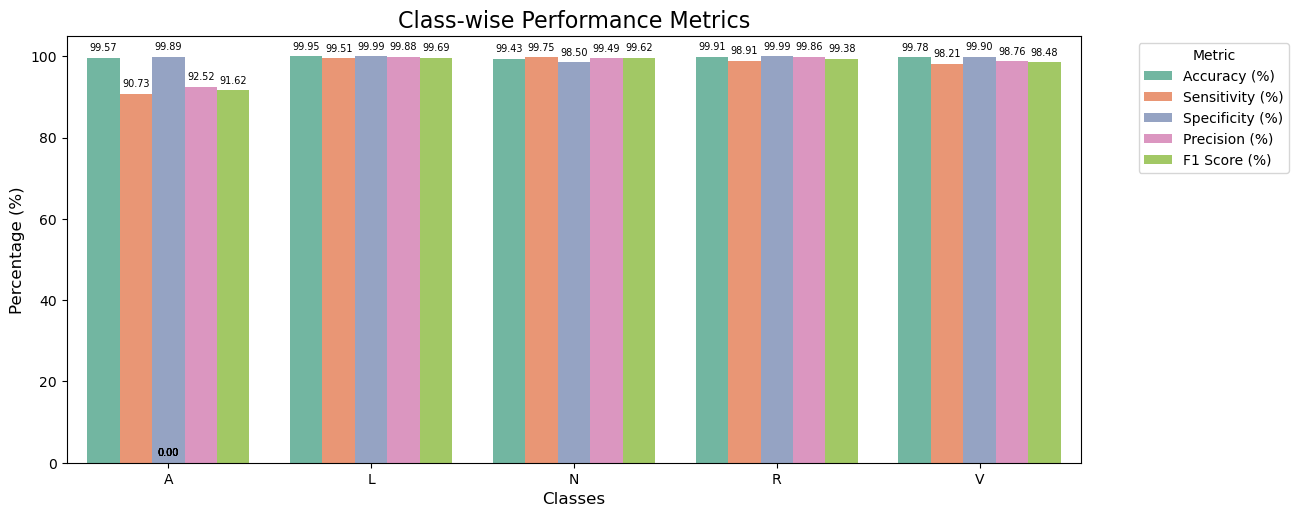

In [55]:
#Create a DataFrame with the values from your screenshot
data = {
    'Classes': ['A', 'L', 'N', 'R', 'V'],
    'Accuracy (%)': [99.570129, 99.950015, 99.430171, 99.910027, 99.780066],
    'Sensitivity (%)': [90.733591, 99.507995, 99.745649, 98.910828, 98.211829],
    'Specificity (%)': [99.885808, 99.989119, 98.498803, 99.989211, 99.902975],
    'Precision (%)': [92.519685, 99.876543, 99.492589, 99.862448, 98.755187],
    'F1 Score (%)': [91.617934, 99.691929, 99.618958, 99.383984, 98.482759]
}

df = pd.DataFrame(data)

# Melt the DataFrame to fit the seaborn barplot requirements
metrics_df_melted = df.melt(id_vars='Classes', var_name='Metric', value_name='Value')

# Set a larger figure size for better readability
plt.figure(figsize=(11, 5))

# Create a grouped bar chart using seaborn with a bright palette
ax = sns.barplot(x='Classes', y='Value', hue='Metric', data=metrics_df_melted, 
                 palette='Set2', dodge=True)
# Add values on top of each bar, rounded to two decimal places
for p in ax.patches:
    value = p.get_height()
    ax.annotate(f'{value:.2f}', 
                (p.get_x() + p.get_width() / 2., value), 
                ha = 'center', va = 'baseline', 
                fontsize=7, color='black', 
                xytext = (0, 5), 
                textcoords = 'offset points')

# Increase the space between bars and adjust the layout
plt.tight_layout()

# Add titles and labels
plt.title('Class-wise Performance Metrics', fontsize=16)
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)

# Display the legend outside the plot
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()



In [66]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score


313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


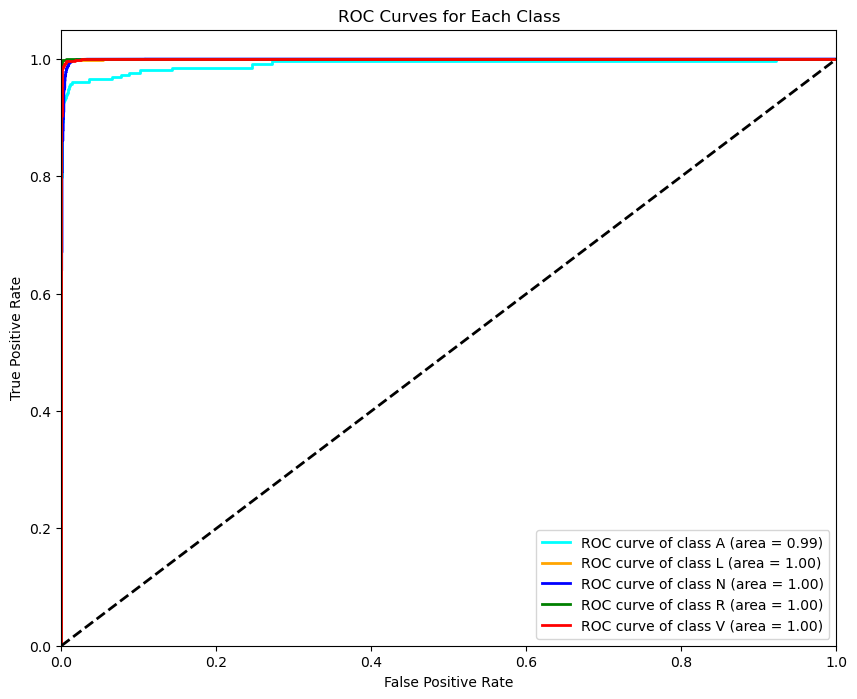

In [65]:
# Predict using the models
y_pred_stacked_gru = stacked_gru_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Ensemble method - Average predictions from the models
y_pred_ensemble = (y_pred_stacked_gru + y_pred_cnn_lstm) / 2

# Ensure y_test is in one-hot format
y_test_classes = np.argmax(y_test, axis=1)  # This gives the class index
n_classes = y_test.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_ensemble[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'orange', 'blue', 'green', 'red'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line representing random guessing
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


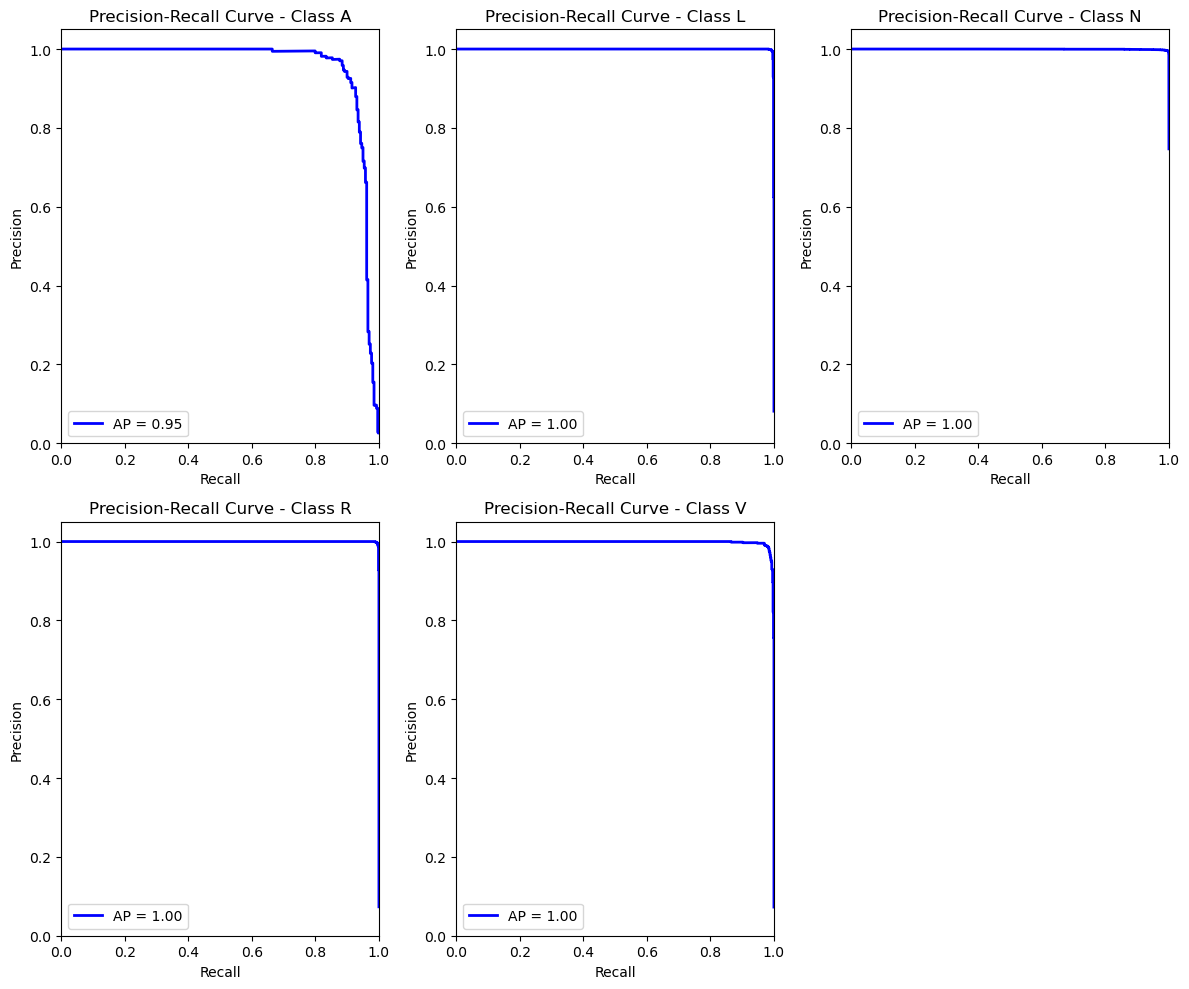

In [67]:
# Predict using the models
y_pred_stacked_gru = stacked_gru_model.predict(X_test)
y_pred_cnn_lstm = cnn_lstm_model.predict(X_test)

# Ensemble method - Average predictions from the models
y_pred_ensemble = (y_pred_stacked_gru + y_pred_cnn_lstm) / 2

# Ensure y_test is in one-hot format
y_test_classes = np.argmax(y_test, axis=1)  # This gives the class index
n_classes = y_test.shape[1]

# Compute Precision-Recall and AUC for each class
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_pred_ensemble[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_pred_ensemble[:, i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 10))

for i in range(n_classes):
    plt.subplot(2, 3, i + 1)
    plt.plot(recall[i], precision[i], lw=2, color='blue', 
             label='AP = {0:0.2f}'.format(average_precision[i]))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Class {class_names[i]}')
    plt.legend(loc='lower left')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])

plt.tight_layout()
plt.show()
